In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor 
import sqlite3
import math
import matplotlib.pyplot as plt
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

/Users/xipengdu/anaconda3/envs/PIC16B-24W/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read in the data from the database
conn = sqlite3.connect('data/tables_split.db')
# show database content
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('df_2023_h1_feature',), ('df_2023_h1_target',), ('df_2023_h1_call',), ('df_2023_h1_put',)]


In [3]:
df_2023_h1_call = pd.read_sql_query("SELECT * from df_2023_h1_call", conn)
conn.close()

In [4]:
df_2023_h1_call

,[QUOTE_DATE],[EXPIRE_DATE],[EXPIRE_UNIX],[STRIKE],[UNDERLYING_LAST],[C_DELTA],[C_GAMMA],[C_VEGA],[C_THETA],[C_RHO],[C_IV],[C_VOLUME],[C_BID],[C_ASK],adj_call_target
0,2023-01-03 00:00:00,2023-09-15 00:00:00,0.502270,0.201754,0.035337,0.92227,0.010511,0.009460,0.920424,0.958921,0.140842,0.000000,0.458415,0.462866,0.000000
1,2023-01-03 00:00:00,2023-06-30 00:00:00,0.137414,0.375439,0.035337,0.66618,0.048225,0.021365,0.855794,0.955811,0.100673,0.000000,0.139490,0.142694,0.000000
2,2023-01-03 00:00:00,2023-12-29 00:00:00,1.000000,0.482456,0.035337,0.39002,0.043632,0.032143,0.910647,0.957144,0.083436,0.000000,0.062701,0.078932,0.000000
3,2023-01-03 00:00:00,2023-06-16 00:00:00,0.071076,0.807018,0.035337,0.00156,0.000618,0.000257,0.998187,0.949626,0.089236,0.000000,0.000000,0.000110,170.757127
4,2023-01-03 00:00:00,2023-06-30 00:00:00,0.137414,0.692982,0.035337,0.00621,0.003268,0.000998,0.995154,0.949674,0.076399,0.000000,0.000258,0.000367,103.032703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78790,2023-05-31 00:00:00,2023-06-30 00:00:00,0.137414,0.578947,0.942822,0.00106,0.001766,0.000094,0.998272,0.949618,0.000202,0.000019,0.000000,0.000000,39.930304
78791,2023-05-31 00:00:00,2023-06-02 00:00:00,0.004738,0.528070,0.942822,0.00190,0.004858,0.000049,0.991883,0.949614,0.120988,0.000000,0.000000,0.000000,27.871607
78792,2023-05-31 00:00:00,2023-06-16 00:00:00,0.071076,0.378947,0.942822,0.91525,0.025967,0.002932,0.717198,0.955567,0.179677,0.000000,0.194888,0.195071,0.000000
78793,2023-05-31 00:00:00,2023-06-07 00:00:00,0.028430,0.526316,0.942822,0.00123,0.005123,0.000067,0.995831,0.949613,0.069661,0.000000,0.000000,0.000000,28.210742


In [25]:
""" # try to put '[QUOTE_DATE]' as timestamps and 'adj_call_target' as target see what happens. 
time_series_call = []
for date in df_2023_h1_call['[QUOTE_DATE]'].unique():
    time_series_call.append(df_2023_h1_call[df_2023_h1_call['[QUOTE_DATE]'] == date].reset_index().drop(['[EXPIRE_DATE]', 'index'], axis = 1))
time_series_call"""

" # try to put '[QUOTE_DATE]' as timestamps and 'adj_call_target' as target see what happens. \ntime_series_call = []\nfor date in df_2023_h1_call['[QUOTE_DATE]'].unique():\n    time_series_call.append(df_2023_h1_call[df_2023_h1_call['[QUOTE_DATE]'] == date].reset_index().drop(['[EXPIRE_DATE]', 'index'], axis = 1))\ntime_series_call"

In [26]:
df_2023_h1_call = df_2023_h1_call.drop('[EXPIRE_DATE]', axis=1)
df_2023_h1_call['item'] = 'SPY'
df_2023_h1_call.shape

(78795, 15)

In [27]:
test_dates = 3
call_train = df_2023_h1_call[: 78795 - (test_dates * 765)]
call_test = df_2023_h1_call[78795 - (test_dates * 765) + 1:]

In [28]:
train_data = TimeSeriesDataFrame.from_data_frame(
    call_train,
    id_column = 'item',
    timestamp_column="[QUOTE_DATE]"
)
train_data.head()

[EXPIRE_UNIX]  [STRIKE]  [UNDERLYING_LAST]  [C_DELTA]  \
item_id timestamp                                                           
SPY     2023-01-03       0.502270  0.201754           0.035337    0.92227   
        2023-01-03       0.137414  0.375439           0.035337    0.66618   
        2023-01-03       1.000000  0.482456           0.035337    0.39002   
        2023-01-03       0.071076  0.807018           0.035337    0.00156   
        2023-01-03       0.137414  0.692982           0.035337    0.00621   

                    [C_GAMMA]  [C_VEGA]  [C_THETA]   [C_RHO]    [C_IV]  \
item_id timestamp                                                        
SPY     2023-01-03   0.010511  0.009460   0.920424  0.958921  0.140842   
        2023-01-03   0.048225  0.021365   0.855794  0.955811  0.100673   
        2023-01-03   0.043632  0.032143   0.910647  0.957144  0.083436   
        2023-01-03   0.000618  0.000257   0.998187  0.949626  0.089236   
        2023-01-03   0.003268  0.000998   0.995154  0.949674  0.076399   

                    [C_VOLUME]   [C_BID]   [C_ASK]  adj_call_target  
item_id timestamp                                                    
SPY     2023-01-03         0.0  0.458415  0.462866         0.000000  
        2023-01-03         0.0  0.139490  0.142694         0.000000  
        2023-01-03         0.0  0.062701  0.078932         0.000000  
        2023-01-03         0.0  0.000000  0.000110       170.757127  
        2023-01-03         0.0  0.000258  0.000367       103.032703

In [31]:
test_data = TimeSeriesDataFrame.from_data_frame(
    call_test,
    id_column = 'item',
    timestamp_column="[QUOTE_DATE]"
)
test_data.head()

[EXPIRE_UNIX]  [STRIKE]  [UNDERLYING_LAST]  [C_DELTA]  \
item_id timestamp                                                           
SPY     2023-05-26       0.502270  0.324561           0.996074    0.92781   
        2023-05-26       0.071076  0.614035           0.996074    0.00082   
        2023-05-26       0.236920  0.359649           0.996074    0.94875   
        2023-05-26       0.018954  0.445614           0.996074    0.91824   
        2023-05-26       0.137414  0.396491           0.996074    0.92462   

                    [C_GAMMA]  [C_VEGA]  [C_THETA]   [C_RHO]    [C_IV]  \
item_id timestamp                                                        
SPY     2023-05-26   0.016781  0.006847   0.884754  0.955040  0.123342   
        2023-05-26   0.000972  0.000070   0.997729  0.949614  0.090223   
        2023-05-26   0.019784  0.003720   0.889482  0.952633  0.110530   
        2023-05-26   0.109433  0.002430   0.770017  0.950249  0.069139   
        2023-05-26   0.036743  0.004064   0.855659  0.951581  0.103266   

                    [C_VOLUME]   [C_BID]   [C_ASK]  adj_call_target  
item_id timestamp                                                    
SPY     2023-05-26    0.000000  0.330911  0.336737         0.000000  
        2023-05-26    0.000000  0.000000  0.000000        63.706247  
        2023-05-26    0.000019  0.247114  0.249357         0.000000  
        2023-05-26    0.000000  0.062442  0.062844         0.000000  
        2023-05-26    0.000000  0.167706  0.170205         0.000000

In [29]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path = 'ag_ts_1', 
    target="adj_call_target",
    freq="D",
    eval_metric="MSE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'ag_ts_1'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.11.6
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.3.0: Wed Dec 20 21:33:31 PST 2023; root:xnu-10002.81.5~7/RELEASE_ARM64_T8112
CPU Count:          8
GPU Count:          0
Memory Avail:       1.38 GB / 8.00 GB (17.2%)
Disk Space Avail:   203.29 GB / 460.43 GB (44.2%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'freq': 'D',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'adj_call_target',
 'time_limit': 600,
 'verbosity': 2}

train_data with frequency 'None' has been resampled t

In [30]:
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-2.308151,9.333838,0.158155,7
1,Theta,-2.681486,7.547091,0.003226,4
2,RecursiveTabular,-2.724143,0.414453,1.464450,5
3,Naive,-2.735196,1.372294,0.003889,1
4,ETS,-4.053553,7.485511,0.002965,3
5,SeasonalNaive,-6.723764,0.657691,0.002827,2
6,DirectTabular,-43.790745,0.019230,0.433280,6


In [36]:
test_data

[EXPIRE_UNIX]  [STRIKE]  [UNDERLYING_LAST]  [C_DELTA]  \
item_id timestamp                                                           
SPY     2023-05-26       0.502270  0.324561           0.996074    0.92781   
        2023-05-26       0.071076  0.614035           0.996074    0.00082   
        2023-05-26       0.236920  0.359649           0.996074    0.94875   
        2023-05-26       0.018954  0.445614           0.996074    0.91824   
        2023-05-26       0.137414  0.396491           0.996074    0.92462   
...                           ...       ...                ...        ...   
        2023-05-31       0.137414  0.578947           0.942822    0.00106   
        2023-05-31       0.004738  0.528070           0.942822    0.00190   
        2023-05-31       0.071076  0.378947           0.942822    0.91525   
        2023-05-31       0.028430  0.526316           0.942822    0.00123   
        2023-05-31       0.033169  0.426316           0.942822    0.94139   

                    [C_GAMMA]  [C_VEGA]  [C_THETA]   [C_RHO]    [C_IV]  \
item_id timestamp                                                        
SPY     2023-05-26   0.016781  0.006847   0.884754  0.955040  0.123342   
        2023-05-26   0.000972  0.000070   0.997729  0.949614  0.090223   
        2023-05-26   0.019784  0.003720   0.889482  0.952633  0.110530   
        2023-05-26   0.109433  0.002430   0.770017  0.950249  0.069139   
        2023-05-26   0.036743  0.004064   0.855659  0.951581  0.103266   
...                       ...       ...        ...       ...       ...   
        2023-05-31   0.001766  0.000094   0.998272  0.949618  0.000202   
        2023-05-31   0.004858  0.000049   0.991883  0.949614  0.120988   
        2023-05-31   0.025967  0.002932   0.717198  0.955567  0.179677   
        2023-05-31   0.005123  0.000067   0.995831  0.949613  0.069661   
        2023-05-31   0.061473  0.001685   0.738431  0.950133  0.105296   

                    [C_VOLUME]   [C_BID]   [C_ASK]  adj_call_target  
item_id timestamp                                                    
SPY     2023-05-26    0.000000  0.330911  0.336737         0.000000  
        2023-05-26    0.000000  0.000000  0.000000        63.706247  
        2023-05-26    0.000019  0.247114  0.249357         0.000000  
        2023-05-26    0.000000  0.062442  0.062844         0.000000  
        2023-05-26    0.000000  0.167706  0.170205         0.000000  
...                        ...       ...       ...              ...  
        2023-05-31    0.000019  0.000000  0.000000        39.930304  
        2023-05-31    0.000000  0.000000  0.000000        27.871607  
        2023-05-31    0.000000  0.194888  0.195071         0.000000  
        2023-05-31    0.000000  0.000000  0.000000        28.210742  
        2023-05-31    0.000019  0.094051  0.094762         0.000000  

[2294 rows x 13 columns]

In [38]:
predictions = predictor.predict(train_data)

data with frequency 'None' has been resampled to frequency 'D'.
data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [47]:
predictions

mean        0.1        0.2        0.3        0.4  \
item_id timestamp                                                           
SPY     2023-05-26  18.330493  16.202357  16.932195  17.458529  17.909879   
        2023-05-27  18.440961  15.434693  16.468106  17.210524  17.845528   
        2023-05-28  18.441010  14.759991  16.024198  16.935017  17.713458   
        2023-05-29  18.451529  14.206590  15.661862  16.712960  17.610663   
        2023-05-30  19.522187  14.779746  16.407695  17.581462  18.583765   
        2023-05-31  19.013824  13.818980  15.602345  16.888770  17.986456   
        2023-06-01  18.027469  12.416475  14.343556  15.731158  16.918558   
        2023-06-02  17.950501  11.952995  14.012630  15.496692  16.763969   
        2023-06-03  17.950503  11.588199  13.772944  15.345866  16.691593   
        2023-06-04  17.950548  11.246885  13.545863  15.207367  16.624666   
        2023-06-05  17.961046  10.928362  13.340838  15.082807  16.571263   
        2023-06-06  19.031677  11.687767  14.206782  16.024944  17.577514   
        2023-06-07  18.523329  10.880869  13.503867  15.395584  17.011951   
        2023-06-08  17.615261   9.685482  12.407061  14.368718  16.044762   
        2023-06-09  17.907321   9.699229  12.515360  14.547086  16.282070   
        2023-06-10  18.017782   9.539401  12.448390  14.545404  16.336323   
        2023-06-11  18.017822   9.280272  12.276646  14.438383  16.286903   
        2023-06-12  18.028300   9.034706  12.120815  14.348876  16.249936   
        2023-06-13  19.098903   9.856058  13.028326  15.316029  17.271482   
        2023-06-14  18.590571   9.113625  12.366026  14.709225  16.712963   
        2023-06-15  17.604291   7.890336  11.222850  13.626249  15.682573   
        2023-06-16  17.527329   7.589448  10.998305  13.457269  15.560334   
        2023-06-17  17.527324   7.362867  10.853915  13.368499  15.515081   
        2023-06-18  17.527359   7.144925  10.707514  13.276541  15.473546   
        2023-06-19  17.537817   6.941049  10.578867  13.201605  15.441382   
        2023-06-20  18.608392   7.797663  11.506158  14.184378  16.469060   
        2023-06-21  18.100076   7.089354  10.869196  13.593946  15.922226   
        2023-06-22  17.192084   5.974493   9.826478  12.600348  14.972292   
        2023-06-23  17.484148   6.074168   9.991338  12.815652  15.228174   
        2023-06-24  17.594602   5.988329   9.972082  12.845249  15.298883   
        2023-06-25  17.594633   5.796827   9.847261  12.767114  15.261497   
        2023-06-26  17.605070   5.614597   9.730502  12.695380  15.233371   
        2023-06-27  18.675618   6.499000  10.678313  13.690933  16.266112   
        2023-06-28  18.167318   5.810557  10.049783  13.109569  15.724339   
        2023-06-29  17.181114   4.647162   8.948856  12.049639  14.701245   
        2023-06-30  17.104157   4.389561   8.754072  11.899297  14.588573   
        2023-07-01  17.104144   4.212292   8.638867  11.828939  14.553631   
        2023-07-02  17.104171   4.035424   8.523610  11.756295  14.518486   
        2023-07-03  17.114588   3.879736   8.424938  11.700299  14.498169   
        2023-07-04  18.185108   4.779378   9.381553  12.697990  15.531683   
        2023-07-05  17.676823   4.104834   8.763220  12.121242  14.990433   
        2023-07-06  16.768906   3.036377   7.748776  11.151131  14.053675   
        2023-07-07  17.060976   3.163503   7.930496  11.373155  14.312259   
        2023-07-08  17.171422   3.115041   7.937443  11.416387  14.391167   
        2023-07-09  17.171445   2.951700   7.833574  11.353126  14.359682   
        2023-07-10  17.181841   2.806097   7.737866  11.296166  14.336142   
        2023-07-11  18.252334   3.719768   8.708920  12.306774  15.377901   
        2023-07-12  17.744065   3.061600   8.099864  11.733080  14.840864   

                          0.5        0.6        0.7        0.8        0.9  
item_id timestamp                                                          
SPY     2023-05-26  18

In [ ]:
item_id = 'SPY'
y_past = train_data.loc[item_id]["adj_call_target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["adj_call_target"][-48:]

In [ ]:
y_pred = predictor.predict(X_test)
print(metrics.r2_score(y_true=y_test, y_pred=y_pred))
print(metrics.mean_squared_error(y_true=y_test, y_pred=y_pred))

0.9905235642099366
136.58152828031177


In [ ]:
r2_list = []
mse_list = []
X_list = []
for i in range(10):
    X_test = ds.iloc[10000 + i * 10000:11000 + i * 10000]
    y_test = target.iloc[10000 + i * 10000:11000 + i * 10000]
    y_pred = predictor.predict(X_test)
    X_list.append(10000 + i * 10000)
    r2_list.append(metrics.r2_score(y_true=y_test, y_pred=y_pred))
    mse_list.append(metrics.mean_squared_error(y_true=y_test, y_pred=y_pred))

Text(0.5, 1.0, 'R2 Score for Autogluon Model')

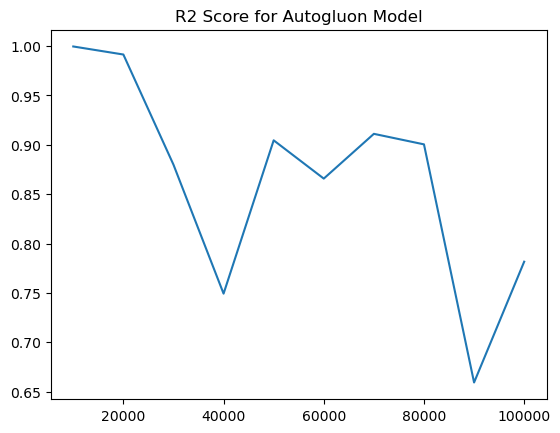

In [ ]:
plt.plot(X_list, r2_list)
plt.title('R2 Score for Autogluon Model')

Text(0.5, 1.0, 'MSE Loss for Autogluon Model')

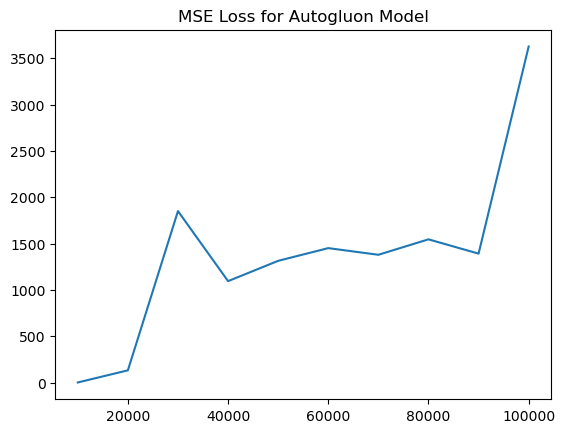

In [ ]:
plt.plot(X_list, mse_list)
plt.title('MSE Loss for Autogluon Model')